In [1]:
from __future__ import print_function
from __future__ import division

import torch
import torchvision
from torchvision import models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import os
import time

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=2,
                                          shuffle=True, num_workers=32)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=2,
                                         shuffle=False, num_workers=32)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

In [3]:
trainset.train_data.shape

torch.Size([60000, 28, 28])

torch.Size([2, 1, 28, 28])
torch.Size([3, 32, 62])
(3, 32, 62)
(32, 62, 3)


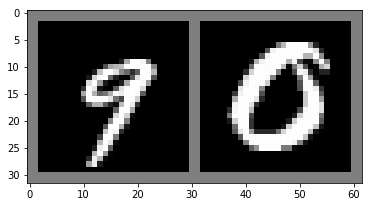

    9     0


In [4]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    print(npimg.shape)
    transposed = np.transpose(npimg, (1, 2, 0))
    print(transposed.shape)
    plt.imshow(transposed)
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)
print(torchvision.utils.make_grid(images).shape)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(len(images))))

In [51]:
class CouplingFunction(nn.Module):
    """ The m coupling function form the paper
        A 5-layer NN with d inputs and D-d outputs
    """

    def __init__(self, in_d, out_d):
        super(CouplingFunction,self).__init__()
        self.net = nn.Sequential(
            nn.Linear(in_d, 1000),
            #nn.LeakyReLU(0.2),
            nn.ReLU(),
            nn.Linear(1000, 1000),
            #nn.LeakyReLU(0.2),
            nn.ReLU(),
            nn.Linear(1000, 1000),
            #nn.LeakyReLU(0.2),
            nn.ReLU(),
            nn.Linear(1000, 1000),
            #nn.LeakyReLU(0.2),
            nn.ReLU(),
            nn.Linear(1000, out_d),
        )
            
    def forward(self, x):
        return self.net(x)

In [6]:
m = CouplingFunction(300, 500)
m

CouplingFunction(
  (net): Sequential(
    (0): Linear(in_features=300, out_features=1000, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=1000, out_features=1000, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=1000, out_features=1000, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1000, out_features=1000, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Linear(in_features=1000, out_features=500, bias=True)
  )
)

In [7]:
flattened_mnist = np.reshape(trainset.train_data,(trainset.train_data.shape[0], trainset.train_data.shape[1]*trainset.train_data.shape[2]))

In [8]:
flattened_batch = np.reshape(images, (images.shape[0], images.shape[1]*images.shape[2]*images.shape[3]))

In [9]:
dimensions = flattened_batch.shape[1]

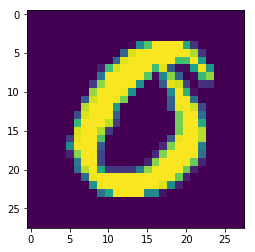

In [10]:
plt.imshow((flattened_batch[1]/ 2 + 0.5).view(28,28))

In [11]:
split_point = flattened_batch.shape[1]//2
x1 = flattened_batch[:,:split_point]
x2 = flattened_batch[:,split_point:]

In [12]:
x2.shape

torch.Size([2, 392])

In [13]:
torch.cat((x1, x2),dim=1).shape

torch.Size([2, 784])

In [52]:
class AdditiveCouplingLayer(nn.Module):
    """
    Additive coupling layer from NICE paper
    y1 = x1
    y2 = x2 + m(x1)
    This version specifies a splitting point - d
    """
    
    def __init__(self, d, D, reverse = 0):
        """
        d is the dimension to use as a splitting point
        D is the total number of dimensions
        """
        super(AdditiveCouplingLayer, self).__init__()
        self.out = (D-d)
        self.input = d
        if reverse:
            self.out = d
            self.input = (D-d)
        self.m = CouplingFunction(self.input, self.out)
        self.reverse = reverse
        
    def forward(self, x, orig_x):
        x1 = x[:,:self.input]
        x2 = x[:,self.input:]
        if not self.reverse:
            y1 = x1
            y2 = x2 + self.m(x1)
        else:
            y1 = x1 + self.m(x2)
            y2 = x2
        log_det = torch.zeros(x.shape[1])
        return torch.cat((y1, y2), dim=1), log_det
    
    def backward(self, y, orig_x):
        y1 = y[:,:self.input]
        y2 = y[:,self.input:]
        if not self.reverse:
            x1 = y1
            x2 = y2 - self.m(y1)
        else:
            x1 = y1 - self.m(y2)
            x2 = y2
        log_det = torch.zeros(y.shape[1])
        return torch.cat((x1, x2), dim=1), log_det

In [15]:
class AdditiveCouplingLayerv2(nn.Module):
    """
    Additive coupling layer from NICE paper
    y1 = x1
    y2 = x2 + m(x1)
    This version splits the odd and even dimensions as mentioned in the paper.
    """
    
    def __init__(self, D, reverse = 0):
        super(AdditiveCouplingLayerv2, self).__init__()
        self.m = CouplingFunction(D//2, D//2)
        self.reverse = reverse
        
    def forward(self, x):
        x1 = x[:,::2]
        x2 = x[:,1::2]
        if not self.reverse:
            y1 = x1
            y2 = x2 + self.m(x1)
        else:
            y1 = x1 + self.m(x2)
            y2 = x2
        log_det = torch.zeros(x.shape[1])
        return torch.cat((y1, y2), dim=1), log_det
    
    def backward(self, y):
        y1 = y[:,::2]
        y2 = y[:,1::2]
        if not self.reverse:
            x1 = y1
            x2 = y2 - self.m(y1)
        else:
            x1 = y1 - self.m(y2)
            x2 = y2
        log_det = torch.zeros(y.shape[1])
        return torch.cat((x1, x2), dim=1), log_det

In [53]:
class Scale(nn.Module):
    """ 
    Scaling applied after the last additive coupling layer that allows the model to assign
    importances to different dimensions
    """
    def __init__(self, size):
        super(Scale, self).__init__()
        self.S = nn.Parameter(torch.randn(1, size, requires_grad=True))
        
    def forward(self, x):
        s = self.S
        z = x * torch.exp(s)
        log_det = torch.sum(s, dim=1)
        return z, log_det
    
    def backward(self, z):
        s = self.S
        x = z * torch.exp(-s)
        log_det = torch.sum(-s, dim=1)
        return x, log_det

In [54]:
from torch.distributions import Uniform, TransformedDistribution, MultivariateNormal
from torch.distributions.transforms import SigmoidTransform, AffineTransform

In [55]:
#Creating a logistic distribution
base_distribution = Uniform(torch.zeros(dimensions).to(device), torch.ones(dimensions).to(device))
transforms = [SigmoidTransform().inv, AffineTransform(loc=0, scale=1)]
logistic = TransformedDistribution(base_distribution, transforms)

#Creating a gaussian distribution
gaussian = MultivariateNormal(torch.zeros(dimensions).to(device), torch.eye(dimensions).to(device))

In [56]:
samples = logistic.sample([1000])

In [57]:
gs = gaussian.sample([1000])

In [58]:
gs.shape

torch.Size([1000, 784])

In [59]:
samples.shape

torch.Size([1000, 784])

In [60]:
torch.sum(torch.rand(1,24),dim=1).shape

torch.Size([1])

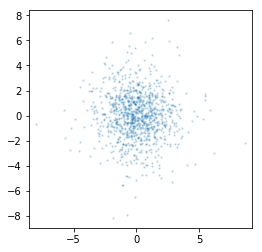

In [61]:
plt.figure(figsize=(4,4))
plt.scatter(samples[:,0].cpu(), samples[:,1].cpu(), s=2, alpha=0.2)
plt.axis('equal');

In [62]:
class NICE(nn.Module):
    """ Normalizing flow used in the NICE paper
        nl - number of additive layers
        sp - splitting point in the dimensional space
        nd - number of dimensions
    """

    def __init__(self, nl, sp, nd):
        super(NICE, self).__init__()
        layer_list = [AdditiveCouplingLayer(sp,nd,i%2) for i in range(nl)]
        #layer_list = [AdditiveCouplingLayerv2(nd,i%2) for i in range(nl)]
        layer_list.append(Scale(nd))
        self.full_layers = nn.ModuleList(layer_list)

    def forward(self, x):
        y = x
        #print(y)
        #going through the layers
        for layer in self.full_layers[:-1]:
            #it doesnt matter that we're overwritting the log-det since only the last one matters
            y, ld = layer.forward(y, x)
            #print(y)
        y, ld = self.full_layers[-1](y)
        #print(y)
        return y, ld

    def backward(self, y):
        x = y
        #First do the scaling layer
        #print(x)
        x, ld = self.full_layers[-1].backward(x)
        #print(x)
        #going through the additive layers in reverse order
        i = len(self.full_layers)-2
        while i >= 0:
            x, _ = self.full_layers[i].backward(x, y)
            i -= 1
            #print(x)
        return x, ld

In [63]:
#Model and optimizer 
model = NICE(5,dimensions//2,dimensions).to(device)
#model = NICE(5,dimensions).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-4)

In [64]:
model

NICE(
  (full_layers): ModuleList(
    (0): AdditiveCouplingLayer(
      (m): CouplingFunction(
        (net): Sequential(
          (0): Linear(in_features=392, out_features=1000, bias=True)
          (1): ReLU()
          (2): Linear(in_features=1000, out_features=1000, bias=True)
          (3): ReLU()
          (4): Linear(in_features=1000, out_features=1000, bias=True)
          (5): ReLU()
          (6): Linear(in_features=1000, out_features=1000, bias=True)
          (7): ReLU()
          (8): Linear(in_features=1000, out_features=392, bias=True)
        )
      )
    )
    (1): AdditiveCouplingLayer(
      (m): CouplingFunction(
        (net): Sequential(
          (0): Linear(in_features=392, out_features=1000, bias=True)
          (1): ReLU()
          (2): Linear(in_features=1000, out_features=1000, bias=True)
          (3): ReLU()
          (4): Linear(in_features=1000, out_features=1000, bias=True)
          (5): ReLU()
          (6): Linear(in_features=1000, out_features=1

Epoch: 0


/home/users/lfguzman/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


batch: 999 loss: 1529.55322266
Sampling


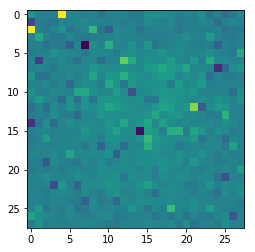

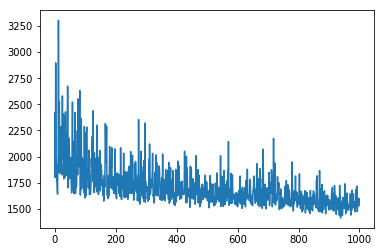

batch: 1999 loss: 1354.40527344
Sampling


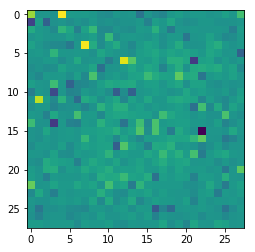

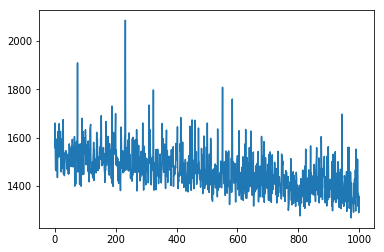

batch: 2999 loss: 1123.31604004
Sampling


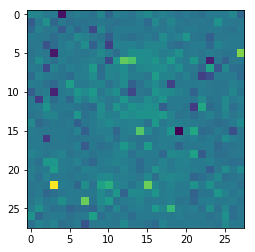

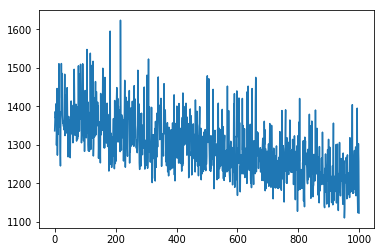

batch: 3999 loss: 1031.78991699
Sampling


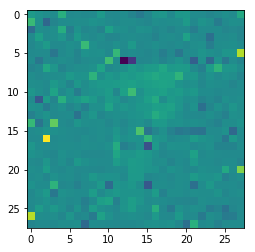

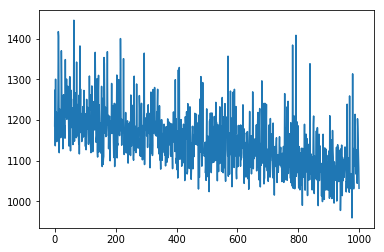

batch: 4999 loss: 1093.45898438
Sampling


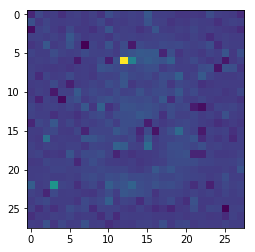

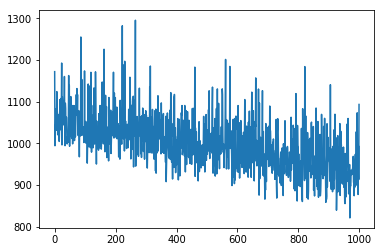

batch: 5999 loss: 755.69543457
Sampling


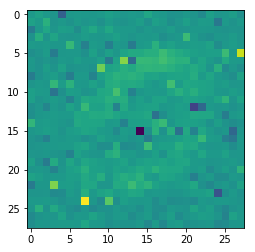

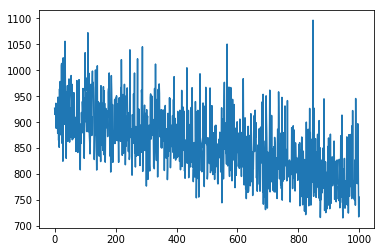

batch: 6999 loss: 668.721923828
Sampling


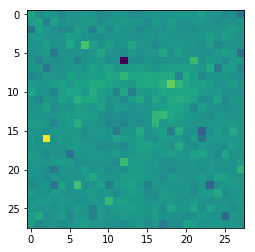

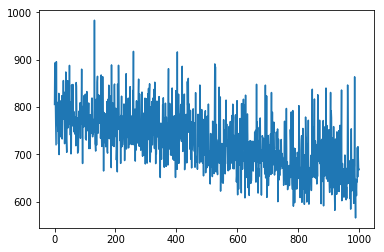

batch: 7999 loss: 570.92175293
Sampling


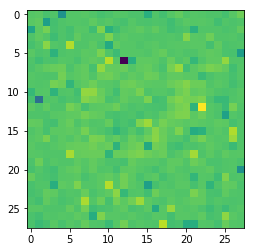

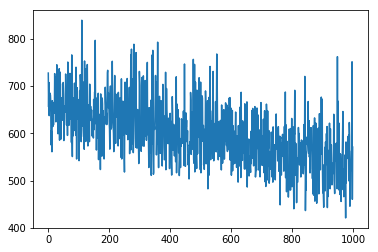

batch: 8999 loss: 293.232910156
Sampling


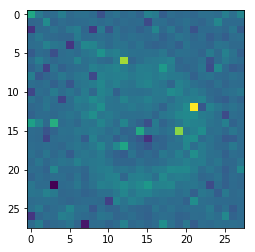

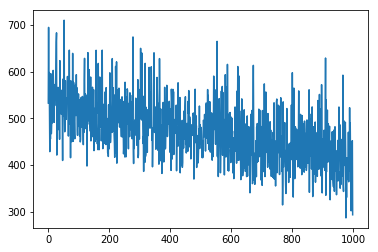

batch: 9999 loss: 365.541992188
Sampling


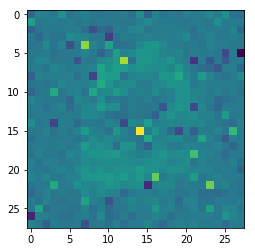

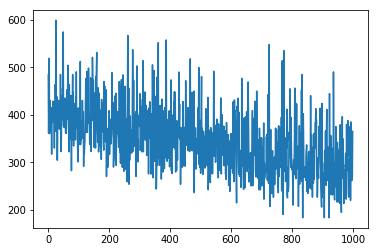

batch: 10999 loss: 156.43347168
Sampling


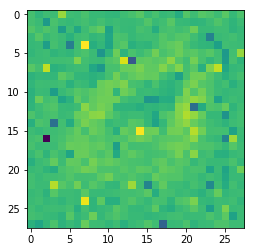

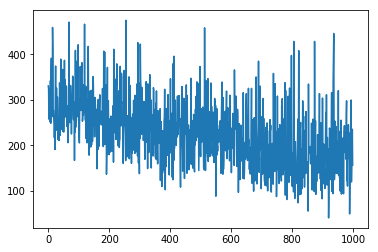

batch: 11999 loss: 49.6507568359
Sampling


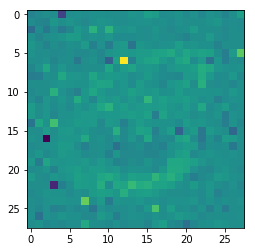

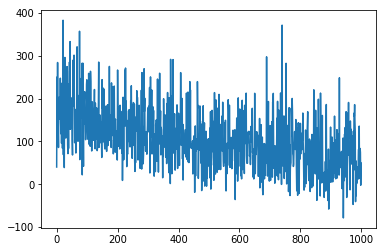

batch: 12999 loss: -58.4657592773
Sampling


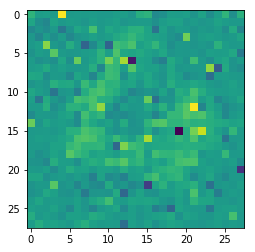

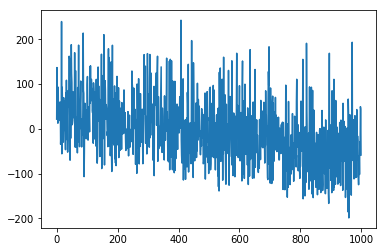

batch: 13999 loss: -224.562744141
Sampling


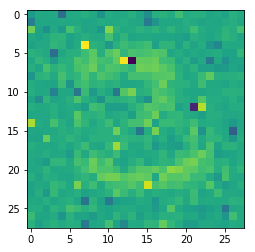

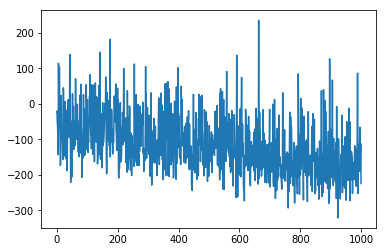

batch: 14999 loss: -177.728149414
Sampling


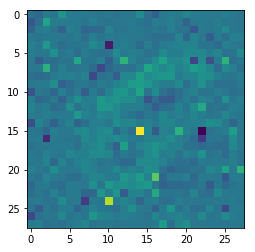

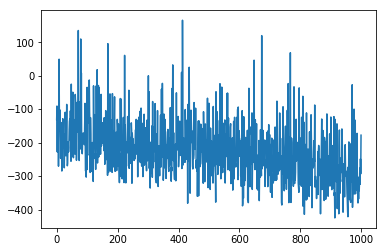

batch: 15999 loss: -336.983398438
Sampling


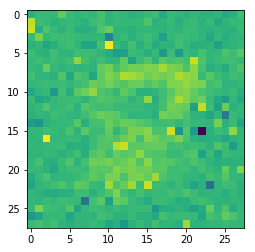

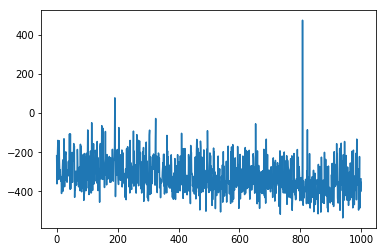

batch: 16999 loss: -452.162963867
Sampling


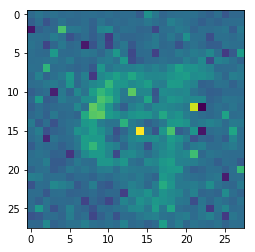

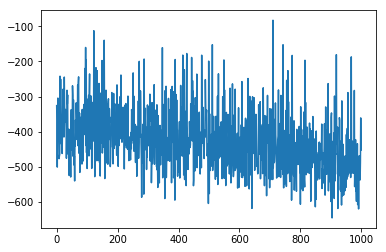

batch: 17999 loss: -595.622497559
Sampling


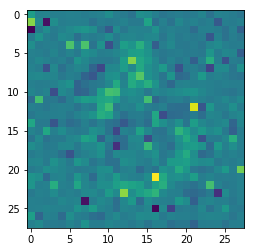

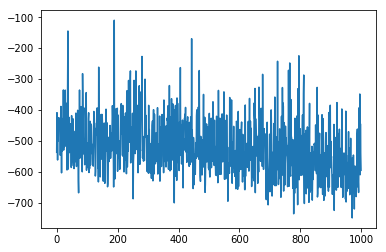

batch: 18999 loss: -711.97064209
Sampling


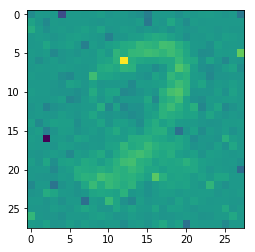

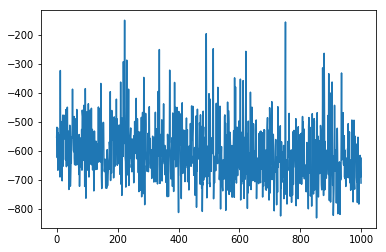

batch: 19999 loss: -820.894165039
Sampling


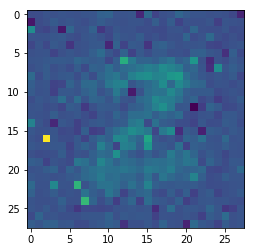

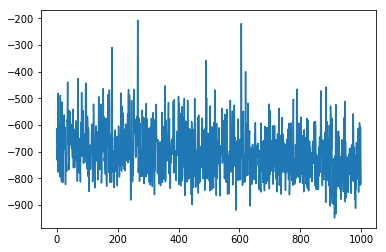

batch: 20999 loss: -926.166015625
Sampling


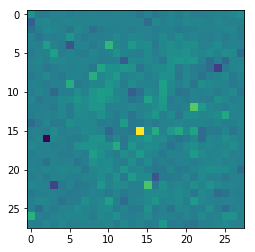

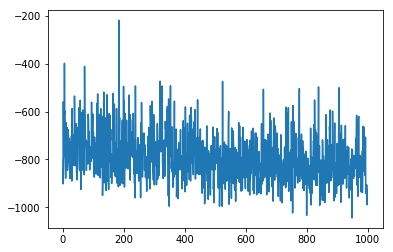

batch: 21999 loss: -948.415649414
Sampling


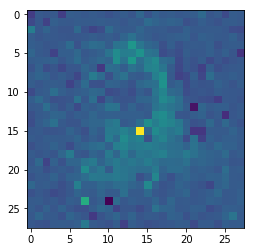

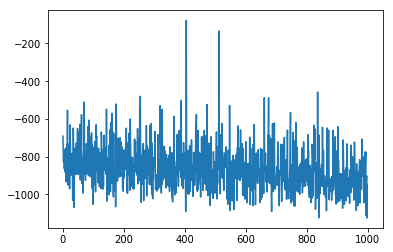

batch: 22999 loss: -1016.55267334
Sampling


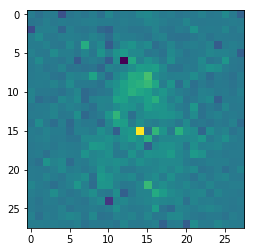

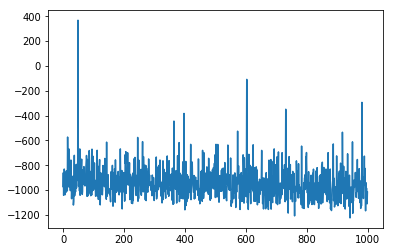

batch: 23999 loss: -1204.1940918
Sampling


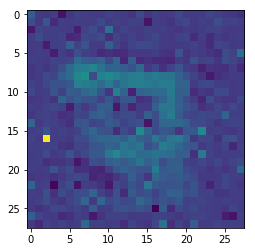

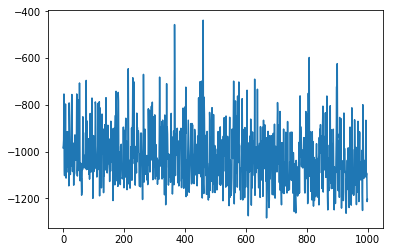

batch: 24999 loss: -1180.65686035
Sampling


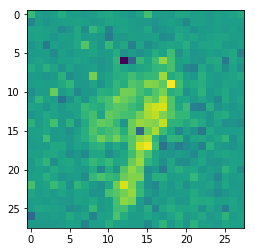

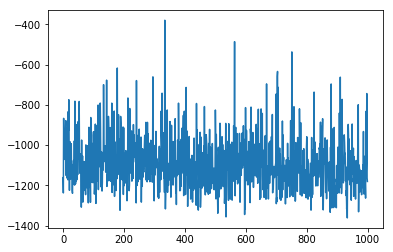

batch: 25999 loss: -1255.39672852
Sampling


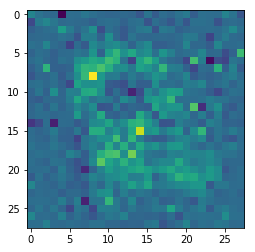

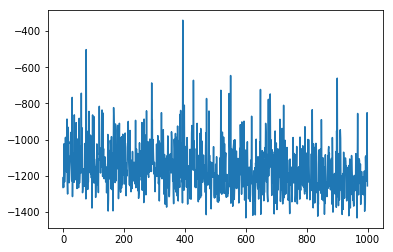

batch: 26999 loss: -1221.18737793
Sampling


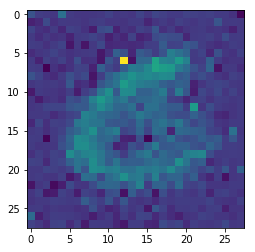

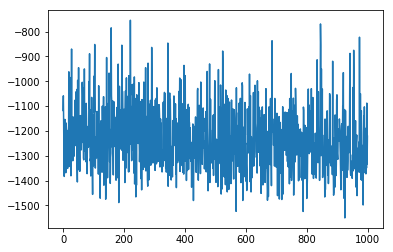

batch: 27999 loss: -1395.63659668
Sampling


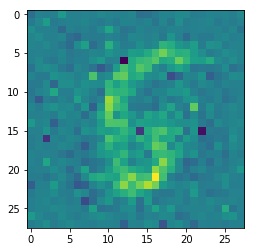

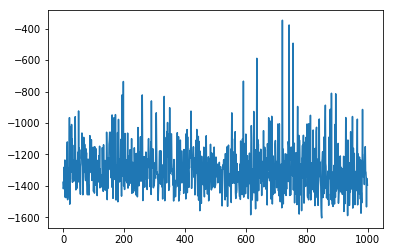

batch: 28999 loss: -1493.71313477
Sampling


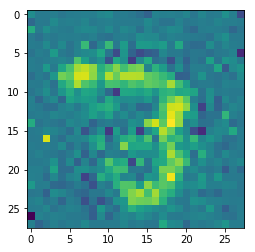

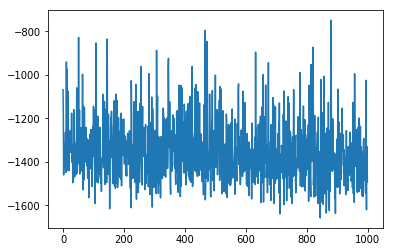

batch: 29999 loss: -1524.86499023
Sampling


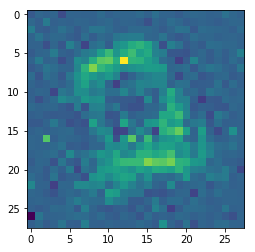

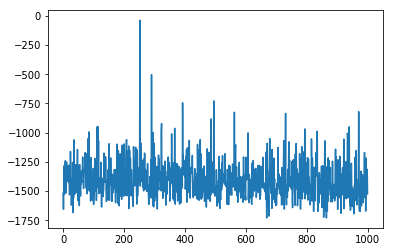

In [65]:
prior = gaussian
model.train()
losses = []
for epoch in range(1):
    print("Epoch:",epoch)
    dataiter = iter(trainloader)
    for batch in range(len(dataiter)):
    #for batch in range(1001):
        #print("batch:",batch)
        images, _ = dataiter.next()
        flattened_batch = np.reshape(images, (images.shape[0], images.shape[1]*images.shape[2]*images.shape[3]))
        flattened_tensor = torch.tensor(flattened_batch/2 + 0.5).to(device)
        #print(flattened_tensor)
        #print(flattened_tensor.shape)
        y, log_det = model.forward(flattened_tensor)
        #avoiding inf values in logprob with logistic #FIXME
        #y[y > 16.5] = 16
        #y[y < -88] = -88
        #########################
        prior_logprob = prior.log_prob(y)
        if prior is logistic:
            prior_logprob = prior_logprob.sum(1)    
        loss = -torch.sum(prior_logprob + log_det)
        losses.append(loss.item())
        
        if loss == float("inf"):
            print(y)
            print(prior.log_prob(y))
            print(prior_logprob)
            print(log_det)
        model.zero_grad()
        loss.backward()
        optimizer.step()

        if (batch+1) % 1000 == 0:
            #losses.append(loss.item())
            print("batch:",batch,"loss:",loss.item())
            print("Sampling")
            h = prior.sample((1,))
            xs, _ = model.backward(h)
            plt.imshow(xs.detach().cpu().view(28,28))
            plt.show()
            plt.plot(losses[-1000:])
            plt.show()

In [ ]:
torch.save(model.state_dict(), "nice.pt")

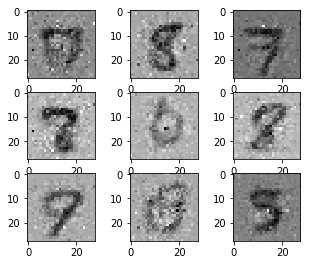

In [110]:
h = prior.sample((9,))
xs, _ = model.backward(h)
xs = xs.detach().cpu().view(-1,28,28)
for i in range(len(xs)):
    plt.subplot(3,3,(i+1))
    plt.imshow(xs[i], cmap=plt.cm.binary)
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
#cax = plt.axes([0.85, 0.1, 0.075, 0.8])
#plt.colorbar(cax=cax)
plt.show()

<function matplotlib.pyplot.show>

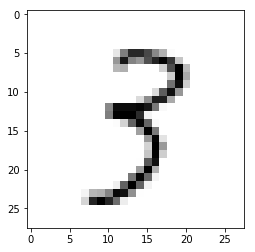

In [101]:
plt.imshow(flattened_tensor[0].cpu().view(28,28), cmap=plt.cm.binary)
plt.show

In [102]:
y,_ = model.forward(flattened_tensor)

<function matplotlib.pyplot.show>

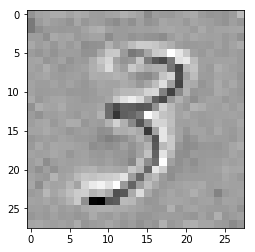

In [103]:
plt.imshow(y[0].detach().cpu().view(28,28), cmap=plt.cm.binary)
plt.show

In [104]:
z,_ = model.backward(y)

<function matplotlib.pyplot.show>

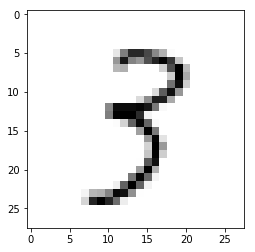

In [105]:
plt.imshow(z[0].detach().cpu().view(28,28), cmap=plt.cm.binary)
plt.show